In [1]:
from bioimageio.spec.pretty_validation_errors import enable_pretty_validation_errors_in_ipynb

enable_pretty_validation_errors_in_ipynb()


## **1.1. Install key dependencies**
---
<font size = 4> 

In [ ]:
#@markdown ##Install CARE and dependencies

#Here, we install libraries which are not already included in Colab.

!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q csbdeep  # contains tools for restoration of fluorescence microcopy images (Content-aware Image Restoration, CARE). It uses Keras and Tensorflow.
!pip install -q wget
!pip install -q memory_profiler
!pip install -q fpdf2

#Force session restart
#exit(0)


## **1.2. Install key dependencies**
---
<font size = 4> 

## Load and inspect a model description

In [2]:
from bioimageio.spec import load_description
from bioimageio.spec.model import ModelDescr
from bioimageio.spec.common import HttpUrl, InvalidDescription

# examples tested with this notebook
IMPARTIAL_SHRIMP = "impartial-shrimp"
PIONEERING_RHINO = "pioneering-rhino"

# example_model_id = IMPARTIAL_SHRIMP
example_model_id = PIONEERING_RHINO

if example_model_id == IMPARTIAL_SHRIMP:
    url = "https://bioimage-io.github.io/collection-bioimage-io/rdfs/10.5281/zenodo.5874741/5874742/rdf.yaml"
elif example_model_id == PIONEERING_RHINO:
    url = "https://bioimage-io.github.io/collection-bioimage-io/rdfs/10.5281/zenodo.6334383/7805067/rdf.yaml"
else:
    raise NotImplementedError(example_model_id)

model = load_description(HttpUrl(url), format_version="latest")  # TODO: load from bioimageio id
if isinstance(model, InvalidDescription):
    raise ValueError(f"Failed to load {url}")
elif not isinstance(model, ModelDescr):
    raise ValueError("This notebook expects a model description")

print(f"loaded '{model.name}'")


Exactly one weights entry may not specify the `parent` field (got 2).That entry is considered the original set of model weights. Other weight formats are created through conversion of the orignal or already converted weights. They have to reference the weights format they were converted from as their `parent`.


loaded '2D UNet Arabidopsis Ovules'


In [3]:
for vs in model.validation_summaries:
    print(vs)


ValidationSummary:
bioimageio.spec validation as model 0.5.0: passed
source: https://bioimage-io.github.io/collection-bioimage-io/rdfs/10.5281/zenodo.6334383/7805067/rdf.yaml
warnings: 
    weights: Exactly one weights entry may not specify the `parent` field (got 2).That entry is considered the original set of model weights. Other weight formats are created through conversion of the orignal or already converted weights. They have to reference the weights format they were converted from as their `parent`.


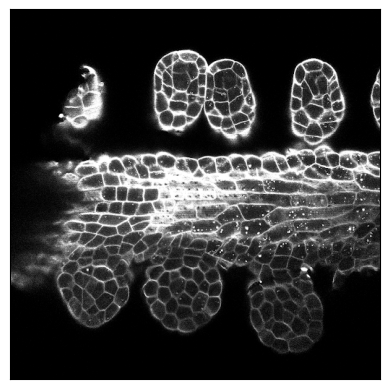

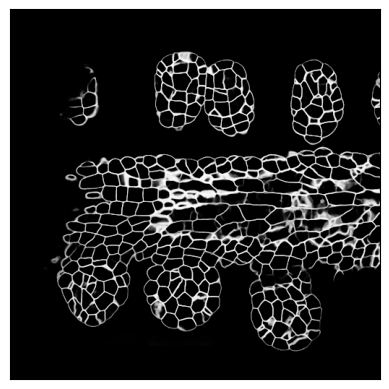

In [4]:
import matplotlib.pyplot as plt
from imageio.v3 import imread

from bioimageio.spec.utils import download

for cover in model.covers:
    cover_data = imread(download(cover).path)
    plt.imshow(cover_data)
    plt.xticks([])
    plt.yticks([])
    plt.show()


the following parts assume we only have a single input and a single output tensor

In [5]:
assert len(model.inputs) == 1
assert len(model.outputs) == 1


In [6]:
from pprint import pprint
import numpy as np

pprint(model.inputs[0].axes)
test_input_path = model.inputs[0].test_tensor.download().path
test_input_array = np.load(test_input_path)
print(test_input_array.shape)


[BatchAxis(id='batch', description='', type='batch', size=None),
 ChannelAxis(id='channel', description='', type='channel', channel_names=['channel1'], size=1),
 SpaceInputAxis(id='y', description='', size=512, type='space', unit=None, scale=1.0),
 SpaceInputAxis(id='x', description='', size=512, type='space', unit=None, scale=1.0)]
(1, 1, 512, 512)


In [7]:
pprint(model.outputs[0].axes)
test_output_path = model.outputs[0].test_tensor.download().path
test_output_array = np.load(test_output_path)
print(test_output_array.shape)


[BatchAxis(id='batch', description='', type='batch', size=None),
 ChannelAxis(id='channel', description='', type='channel', channel_names=['channel1'], size=1),
 SpaceOutputAxis(halo=0, id='y', description='', size=512, type='space', unit=None, scale=1.0),
 SpaceOutputAxis(halo=0, id='x', description='', size=512, type='space', unit=None, scale=1.0)]
(1, 1, 512, 512)


In [8]:
assert model.weights.pytorch_state_dict is not None
pytorch_state_dict_weights_src = model.weights.pytorch_state_dict.download().path
print(pytorch_state_dict_weights_src)
assert model.weights.torchscript is not None
torchscript_weights_src = model.weights.torchscript.download().path
print(torchscript_weights_src)


C:\Users\fbeut\AppData\Local\pooch\pooch\Cache\a9b5dc7a7478a025c4fddaa522c8a848-confocal_2D_unet_ovules_ds2x.pytorch
C:\Users\fbeut\AppData\Local\pooch\pooch\Cache\da48973f3334872f9d49ae5fb1c824e8-torchscript_tracing.pt


In [9]:
from bioimageio.spec.model.v0_5 import ArchitectureFromFileDescr
from bioimageio.spec.utils import download

assert model.weights.pytorch_state_dict is not None
arch = model.weights.pytorch_state_dict.architecture
assert isinstance(arch, ArchitectureFromFileDescr)
print(f"Model architecture given by '{arch.callable}' in {arch.source}")
print("architecture key word arguments:")
pprint(arch.kwargs)
arch_file_path = download(arch.source, sha256=arch.sha256).path
arch_file_sha256 = arch.sha256
arch_name = arch.callable
arch_kwargs = arch.kwargs


Model architecture given by 'UNet2D' in https://zenodo.org/api/files/007d530f-a270-4e8c-812f-4459dad6f079/unet.py
architecture key word arguments:
{'f_maps': 64,
 'final_sigmoid': True,
 'in_channels': 1,
 'is_segmentation': True,
 'layer_order': 'gcr',
 'num_groups': 8,
 'out_channels': 1}


## Create a model description

Let's recreate a model based on parts of the loaded model description from above!

Creating a model description in Python means creating a `ModelDescr` object.
Without any input data this will raise a `ValidationError` listing missing fields that are required:

In [10]:
from bioimageio.spec.common import ValidationError
from bioimageio.spec.model.v0_5 import ModelDescr


try:
    my_model_descr = ModelDescr()  # type: ignore
except ValidationError as e:
    print(e)


9 validation errors for bioimage.io model specification
name
  Field required [type=missing, input_value={'type': 'model', 'format_version': '0.5.0'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.4/v/missing
description
  Field required [type=missing, input_value={'type': 'model', 'format_version': '0.5.0'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.4/v/missing
authors
  Field required [type=missing, input_value={'type': 'model', 'format_version': '0.5.0'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.4/v/missing
cite
  Field required [type=missing, input_value={'type': 'model', 'format_version': '0.5.0'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.4/v/missing
documentation
  Field required [type=missing, input_value={'type': 'model', 'format_version': '0.5.0'}, input_type=dict]
    For further information visit https://errors.pydantic.dev

to populate a `ModelDescr` appropriately we create the required subparts.
Let's start with the inputs:

In [11]:
from bioimageio.spec.model.v0_5 import AxisId, BatchAxis, ChannelAxis, ModelDescr, Author, FileDescr, SpaceInputAxis, TensorAxisId, IntervalOrRatioDataDescr, WeightsDescr, PytorchStateDictWeightsDescr, TorchscriptWeightsDescr, CiteEntry, InputTensorDescr, OutputTensorDescr, ParameterizedSize, TensorId, SpaceOutputAxis, ArchitectureFromFileDescr, Version, Identifier, Doi

input_axes = [
    BatchAxis(),
    ChannelAxis(size=1)]
if example_model_id == "impartial-shrimp":
    input_axes += [
        SpaceInputAxis(id=AxisId("z"), size=ParameterizedSize(min=16, step=8)),
        SpaceInputAxis(id=AxisId('y'), size=ParameterizedSize(min=144, step=72)),
        SpaceInputAxis(id=AxisId('x'), size=ParameterizedSize(min=144, step=72)),
    ]
    data_descr = IntervalOrRatioDataDescr(type="uint8")
elif example_model_id == "pioneering-rhino":
    input_axes += [
        SpaceInputAxis(id=AxisId('y'), size=ParameterizedSize(min=256, step=8)),
        SpaceInputAxis(id=AxisId('x'), size=ParameterizedSize(min=256, step=8)),
    ]
    data_descr = IntervalOrRatioDataDescr()
else:
    raise NotImplementedError(f"Recreating inputs for {example_model_id} is not implemented")

input_descr = InputTensorDescr(id=TensorId("raw"), axes=input_axes, test_tensor=FileDescr(source=test_input_path), data=data_descr)


... and describe the outputs very similarly:

In [12]:
output_axes = [
    BatchAxis(),
    ChannelAxis(size=1)]
if example_model_id == "impartial-shrimp":
    output_axes += [
        SpaceInputAxis(id=AxisId("z"), size=ParameterizedSize(min=16, step=8)),  # implicitly same size as raw.z as it is parametrized the same.
        SpaceInputAxis(id=AxisId('y'), size=ParameterizedSize(min=144, step=72)),
        SpaceInputAxis(id=AxisId('x'), size=ParameterizedSize(min=144, step=72))
    ]
elif example_model_id == "pioneering-rhino":
    output_axes += [
        SpaceOutputAxis(id=AxisId("y"), size=TensorAxisId('raw.y')),  # explicitly same size as raw.y
        SpaceOutputAxis(id=AxisId("x"), size=TensorAxisId('raw.x')),
    ]
else:
    raise NotImplementedError(f"Recreating outputs for {example_model_id} is not implemented")

output_descr = OutputTensorDescr(id=TensorId("prob"), axes=output_axes, test_tensor=FileDescr(source=test_output_path))


... and finish with describing the architecutre needed for the pytorch state dict weights:

In [13]:
from bioimageio.spec.model.v0_5 import ArchitectureFromFileDescr, Version

try:
    import torch
except ImportError:
    pytorch_version = Version("1.15")
else:
    pytorch_version = Version(torch.__version__)

pytorch_architecture = ArchitectureFromFileDescr(source=arch_file_path, sha256=arch_file_sha256, callable=arch_name, kwargs=arch_kwargs)


now, we are ready to create a new model:

In [14]:
my_model_descr = ModelDescr(
    name="My cool model",
    description="A test model for demonstration purposes only",
    authors=[Author(name="me", affiliation="my institute", github_user="your GitHub account name")],
    cite=[CiteEntry(text="for model training see my paper", doi=Doi("10.1234something"))],
    license="MIT",
    documentation=HttpUrl("https://raw.githubusercontent.com/bioimage-io/spec-bioimage-io/main/README.md"),
    git_repo=HttpUrl("https://github.com/bioimage-io/spec-bioimage-io"),  # change to repo where your model is developed
    inputs=[input_descr],
    outputs=[output_descr],
    weights=WeightsDescr(
        pytorch_state_dict=PytorchStateDictWeightsDescr(
            source=pytorch_state_dict_weights_src,
            architecture=pytorch_architecture,
            pytorch_version=pytorch_version
        ),
        torchscript=TorchscriptWeightsDescr(
            source=torchscript_weights_src,
            pytorch_version=pytorch_version,
            parent="pytorch_state_dict", # these weights were converted from the pytorch_state_dict weights ones.
        ),
    ),
    )

print("created '{my_model_descr.name}'")


created '{my_model_descr.name}'


some optional fields were filed with default values, e.g. as we did not specify `covers`, a default visualization of the test inputs and test outputs was used:

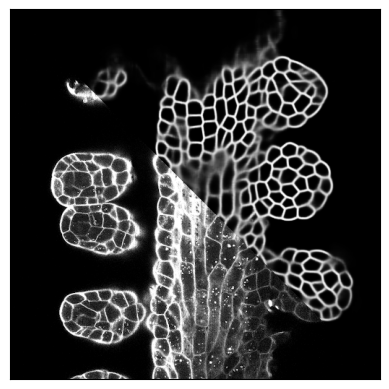

In [15]:
for cover in my_model_descr.covers:
    plt.imshow(imread(cover))
    plt.xticks([])
    plt.yticks([])
    plt.show()


## test your model

In [23]:
from bioimageio.core import test_model

summaries = test_model(my_model_descr)
for s in summaries:
    print(s)
